# Курс "Практикум по математической статистике"
# 3 курс ФПМИ МФТИ, осень 2023
## Домашнее задание 0. Численное моделирование случайных величин. Графическая интерпретация результатов
### Дедлайн --- 21 сентября 23:59

Это первое обязательное домашнее задание нашего курса. Мы предлагаем выполнять задания прямо в этом ноутбуке. Пожалуйста, не стирайте условия задач.

---

В этом и последующих заданиях вам потребуется выполнять генерацию случайных величин из некоторого распределения, моделирование оценок параметров и проверку их теоретических свойств на практике. Для этого вам понадобится библиотека scipy.stats. Мы настоятельно рекомендуем для генерации выборок использовать именно эту библиотеку.

Настоятельно рекомендуемая форма оформления домашних заданий — это Jupyter Notebook и его pdf-версия с:

* условием задачи,
* решением (если требуется некоторый теоретический вывод),
* описанием плана решения, который потом реализуется в коде,
* собственно кодом,
* построенными графиками (если это требуется) и **выводом**, который как правило должен заключаться в объяснении практических результатов с использованием теоретических фактов. ***Вывод требуется даже в том случае, если в условии об этом явно не сказано!***
* некоторыми другими вещами, если об этом будет указано в задании.

Оценка за каждую задачу складывается из правильного выполнения всех этих пунктов. Закрывая на них глаза, вы сознательно понижаете свою оценку.

Каждая задача оценивается в 10 баллов.

In [16]:
# Matplotlib needed to correctly display suptitles,
# as well as some other minor things.
# I thought I might as well ensure everything is up to date
%pip install --upgrade matplotlib numpy scipy statsmodels

  Using cached numpy-2.1.1-cp310-cp310-win_amd64.whl.metadata (59 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
from __future__ import annotations
import typing
import abc
import dataclasses
import itertools

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import seaborn as sns

sns.set(style='darkgrid')
%matplotlib inline

**Зафиксируем** `seed` для воспроизводимости.

In [19]:
np.random.seed(42)



```
# Выбран кодовый формат
```

**Условие задания**: Во всех домашних заданиях практики по статистике Вы будете видеть ключевое слово "промоделируйте" и требование построить график с целью проверки некоторых свойств. В этом домашнем задании мы предлагаем Вам потренировать эти навыки на модельных примерах.

**Гайд, как моделировать оценки**:

Если Вам неизвестно слово "оценка", то всюду считайте, что это случайная величина $\theta = \theta(X_1, ..., X_n)$, где $X_i$ --- одинаково распределённые элементы из некоторого распределения. Позже на лекции термин "оценка" введут строго.

Для моделирования оценки необходимо сгенерировать большое число выборок из одного распределения, построить по каждой из выборок оценку и получить выборку оценок. Далее по выборке оценок можно построить эмпирическую плотность, и на её основе делать какие-то выводы.

Условие домашки.

Аспект-император (тот самый) Анасуримбор Келлхус отдал приказ готовить великую ордалию к походу на север --- в цитадель хаотичного зла. Так как путь пройдёт через кишащие чудовищами голодные пустоши, то путешествие должно быть тщательно спланировано, чтобы армия дошла в полном составе.

Для этого имперские математики моделируют всевозможные проблемы и их решения, чтобы предотвратить потенциальные трудности. На севере никто никогда не был, никто никогда с него не возращался, так что прямого доступа к законам природы севера нет. Однако, есть некоторые догадки и результаты экспериментов, распределения, которые Вы можете генерировать из коробки.

Убедите Аспект-Императора в том, что Вы умеете правильно считать сложные величины и проверять сложные закономерности.

### Задача 1

В данной задаче Вы научитесь численно получать значения из сложных распределений на примере распределения Фишера.

Нашей финальной целью будет промоделировать распределение Фишера и получить точные оценки его мат. ожидания и дисперсии.

**Внимание!**

В рамках данной задачи разрешено генерировать только нормально распределённые величины. Остальные можно получать из них.

Распределение Фишера с степенями свободы $(d_1, d_2)$ представляет собой распределение следующей случайной величины: $F \stackrel{d}{=} \frac{Y_1/d_1}{Y_2/d_2}$, где $Y_i$ --- величина из распределения хи-квадрат со степенью свободы $d_i$, то есть  $Y_i \stackrel{d}{=} \sum\limits_{j = 1}^{d_i} X_{i, j}^2$, где $X_{i, 1}, \ldots, X_{i, d_i}$ независимы и взяты из стандартного нормального распределения.

Распределение Фишера является предельным распределением для построения множества гипотез в статистике, так что его сэмплирование представляет собой важную задачу для численного анализа (и принятия решений).

От распределения Фишера нам нужно две вещи: плотность распределения (для изучения его поведения) и количественные свойства (моменты, для примера).

Фишер вывел формулу плотности распределения аналитически, так что процесс сэмплирования можно проводить одношагово, но это не наш путь. Мы будем получать плотность при помощи KDE, считая её неизвестной (как происходит на практике для величин, плотности которых у нас нет).

Для этого нам нужно получить выборку из распределения Фишера размером хотя бы $N = 1000$ или больше.

Сгенерируйте такую выборку, используя формулы выше. В качестве степеней свободы возьмите значения $d_1 = 5$, $d_2 = 7$. Не забудьте, что элементы выборки должны быть не только одинаково распределёнными, но и независимыми в совокупности.

In [20]:
N = 1000
d_1 = 5
d_2 = 7
# Функция для генерации выборки с распределением Фишера
def GenerateFisher(N, d_1, d_2):
    Y_1 = np.sum(sps.norm(0,1).rvs(size=(N, d_1))**2, axis = 1)
    Y_2 = np.sum(sps.norm(0,1).rvs(size=(N, d_2))**2, axis = 1)
    F_sample = (Y_1/d_1)/(Y_2/d_2)
    return F_sample
F_sample = GenerateFisher(N, d_1, d_2)

Вспомните, как работает KDE для вычисления плотности по выборке. Прочитайте документацию: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html

Постройте в одних осях KDE по Вашей выборке и теоретическую плотность [распределения Фишера](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f.html), взятую из scipy.

In [21]:
from scipy.stats import gaussian_kde
from scipy.stats import f

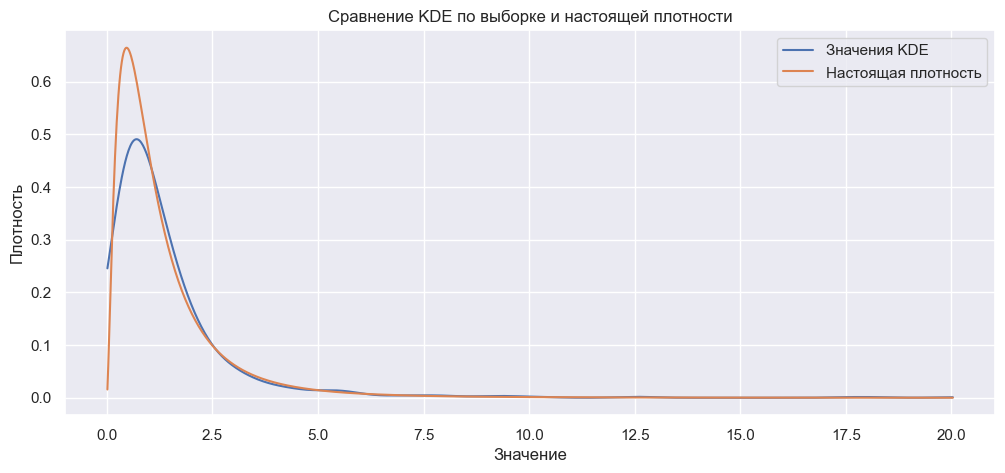

In [22]:
kde = gaussian_kde(F_sample)
x_values = np.linspace(min(F_sample), max(F_sample), 1000)
plt.figure(figsize=(12,5))
# Оценка плотности для каждого значения
kde_values = kde(x_values)
real_values = f.pdf(x_values, d_1, d_2)
plt.plot(x_values, kde_values, label="Значения KDE")
plt.plot(x_values, real_values, label="Настоящая плотность")

plt.title('Сравнение KDE по выборке и настоящей плотности')
plt.xlabel('Значение')
plt.ylabel('Плотность')

plt.legend()
plt.show()

Похожи ли графики? О чём это говорит?

Ответ: Графики похожи, так как видно, что они оба сначала возрастают до какой-то точки а потом начинают убывать. Однако при достаточно малых значениях KDE меньше настоящего значения плотности. Это может быть связано с малым размером выборки.

Посмотрите на поведение KDE для разных размеров выборки. Рекомендуем брать не более трёх вариантов, чтобы не захламлять график, возьмите значения как больше, так и меньше изначального $N$ (особенно если ячейки долго работают). Как меняется вид оценки?

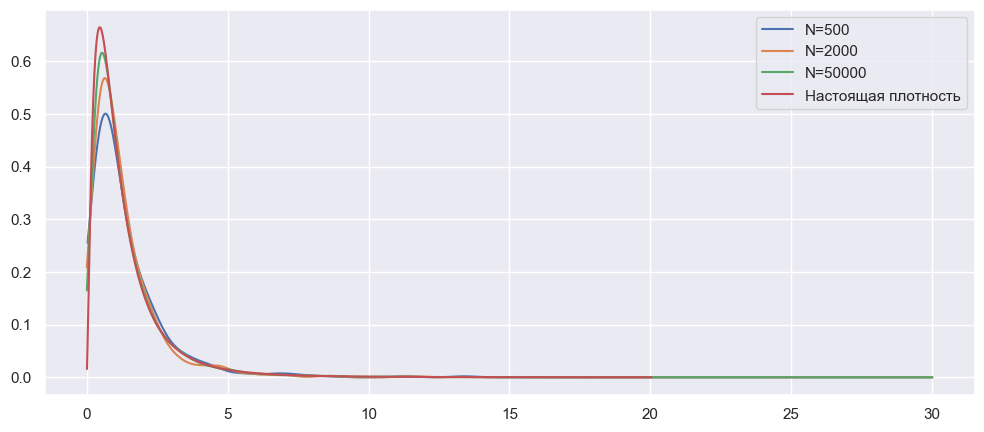

In [23]:
N_1 = 500
N_2 = 2000
N_3 = 50000

plt.figure(figsize=(12,5))

F_sample_500 = GenerateFisher(N_1, d_1, d_2)
F_sample_2000 = GenerateFisher(N_2, d_1, d_2)
F_sample_50000 = GenerateFisher(N_3, d_1, d_2)

kde_1 = gaussian_kde(F_sample_500)
kde_2 = gaussian_kde(F_sample_2000)
kde_3 = gaussian_kde(F_sample_50000)

x_values_1 = np.linspace(min(F_sample_500), 30, N_3)
x_values_2 = np.linspace(min(F_sample_2000), 30, N_3)
x_values_3 = np.linspace(min(F_sample_50000), 30, N_3)

plt.plot(x_values_1, kde_1(x_values_1), label="N=500")
plt.plot(x_values_2, kde_2(x_values_2), label="N=2000")
plt.plot(x_values_3, kde_3(x_values_3), label="N=50000")
plt.plot(x_values, real_values, label="Настоящая плотность")

plt.legend()

plt.show()


По графикам видно, что при большей выборки графики при малых значениях больше и ближе к графику настоящей плотности.

Используя первоначальную выборку, посчитайте мат. ожидание и дисперсию распределения Фишера. Посчитайте теоретически мат. ожидание и дисперсию (формулы есть на Википедии). Сравните результаты.

In [24]:
sample_mean = np.mean(F_sample)
sample_variance = np.var(F_sample)
real_mean = d_2/(d_2-2)
real_variance = (2 * d_2**2 * (d_1+d_2-2))/(d_1 * (d_2-2)**2 * (d_2-4))
print(f"Мат ожидание по выборке:{sample_mean}, Мат ожидание распределения фишера {real_mean}")
print(f"Дисперсия по выборке:{sample_variance}, дисперсия распределения фишера {real_variance}")

Мат ожидание по выборке:1.4053240642052165, Мат ожидание распределения фишера 1.4
Дисперсия по выборке:2.944520343752366, дисперсия распределения фишера 2.6133333333333333


Проверьте, что с ростом $N$ эмпирические мат. ожидание и дисперсия сходятся к теоретическим. Сделайте выводы.

In [25]:
sample_mean_500 = np.mean(F_sample_500)
sample_mean_2000 = np.mean(F_sample_2000)
sample_mean_50000 = np.mean(F_sample_50000)
sample_variance_500 = np.var(F_sample_500)
sample_variance_2000 = np.var(F_sample_2000)
sample_variance_50000 = np.var(F_sample_50000)
print("Мат ожидание и дисперсия для N=500, 2000, 50000:")
print(f"Мат ожидания: {sample_mean_500}, {sample_mean_2000}, {sample_mean_50000}, настоящее матожидание: {real_mean}")
print(f"Дисперсия: {sample_variance_500}, {sample_variance_2000}, {sample_variance_50000}, настоящая дисперсия {real_variance}")


Мат ожидание и дисперсия для N=500, 2000, 50000:
Мат ожидания: 1.3714521625593092, 1.316233526113636, 1.393079164518031, настоящее матожидание: 1.4
Дисперсия: 2.036311656641707, 1.7359805996091668, 2.5465363692254863, настоящая дисперсия 2.6133333333333333


По значениям эмпирических матожиданий и дисперсий видно, что они действительно с ростом выборки становятся ближе к действительному значению.

Вспомните, как работает QQ-plot.

Прочитайте документацию: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html

QQ-plot является хорошим прикладным инструментом проверки распределения на принадлежность семейству. Проверьте, что Ваша выборка действительно является выборкой из распределения Фишера, построив QQ-plot

In [26]:
from scipy.stats import probplot

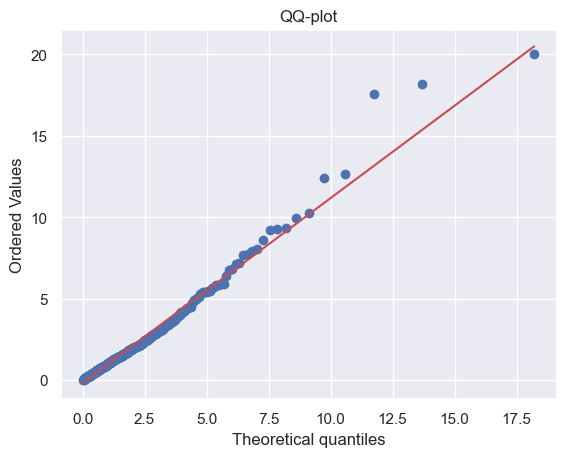

In [27]:
probplot(F_sample, sparams=(d_1, d_2), dist="f", plot=plt)

plt.title("QQ-plot")
plt.show()

Какие выводы можно сделать, если точки в хвостах QQ-plot находятся выше/ниже своей прямой, как на картинке ниже? А если оба "хвоста" находятся с одной стороны прямой?

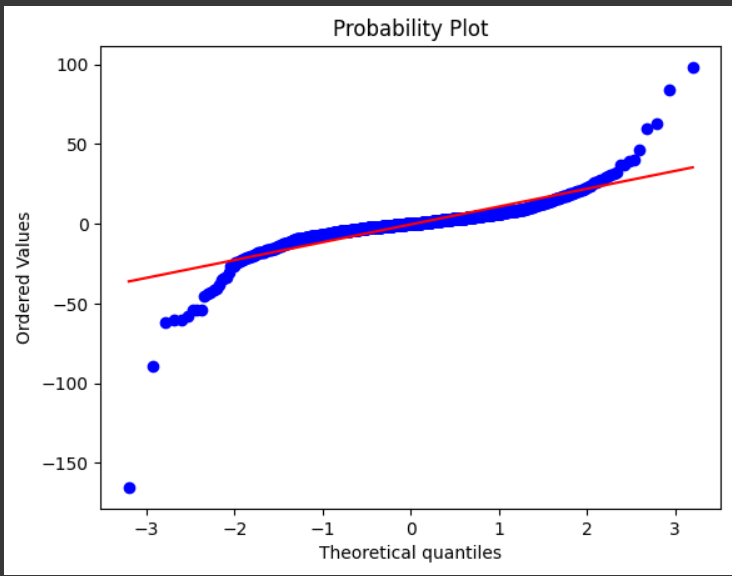

Ответ: Отклонения в хвостах Q-Q графика являются показателем того, что данные либо обладают более "тяжелыми" хвостами, либо более "тонкими", чем в теоретическом распределении. В случае тяжелых хвостов это значит, что вероятность экстремальных значений выше, чем предсказывает наше распределение. в случае тонких хвостов вероятность экстремальных значений меньше, чем в нашем распределении.

Оба хвоста с одной стороны прямой могут говорить об асимметрии данных или специфических аномалиях в поведении экстремальных значений.

### Задача 2

В данной задаче Вам предстоит проверить истинность дельта-метода на практике, используя KDE.

Формулировка теоремы о дельта-методе представлена в методичке курса, глава 1, теорема 1.4.

Нас же интересует задача 3 из списка задач для самостоятельного решения.

####Условие.
Дана выборка $X_i$ из $N(0, \sigma^2)$,

$Y = \frac{1}{n}\sum_1^n |X_i|$,

$Z = \frac{1}{n}\sum_1^n X_i^2$.

$T = \sqrt{\frac{2}{\pi}}\frac{Z}{Y}$. Куда сходится $P = \sqrt{n}(T - \sigma)$ по распределению?

Скорее всего, Вы решали эту задачу на семинаре. Или решал Ваш сосед по комнате. В любом случае, известно, что предел --- это нормальное распределение с нулевым средним. Посчитайте дисперсию предельного распределения и напишите ответ ниже.

Ответ: $\sigma^2 * (\pi/2 - 1)$

Теперь попробуем увидеть, как ведёт себя величина $T$ и проверить, что она сходится по распределению.

Наш план:

1) Построить выборку независимых величин $P$.

2) Построить хорошее приближение плотности $P$ для каждого $n$.

3) Изучить, как ведёт себя плотность с ростом $n$.

4) Сделать вывод о наличии сходимости по распределению к величине с заданной плотностью.

Рекомендуем Вам изначально зафиксировать несколько вариантов $\sigma$ и проводить параллельное решение каждого пункта задачи для каждого значения.

1) Необходимо построить выборку из величин $P$.

Каждая величина $P$ не может быть сгенерирована напрямую, так что необходимо сгенерировать выборку величин $X_i$ --- по $n$ штук для каждого $P$. Так мы приходим к понятию "выборка выборок".

Сгенерируйте N выборок $X_1, \dots, X_N$ из нормального распределения $N(0, \sigma^2)$ для $N = 10^4$. Если у Вас долго считаются формулы, можете понизить $N$ до 100. Не забывайте про векторные вычисление numpy!

In [64]:
N = 10000
n = 10000
sigmas = [1, 5, 10]
samples_of_samples = {}
for sigma in sigmas:
    samples_of_samples[sigma] = sps.norm(0, sigma).rvs(size=(N, n))

Для всех $N$ выборок посчитайте $P$.

__Подсказка:__ Могут быть полезными функции `np.arange`, `np.cumsum`, `np.maximum.accumulate` и `np.minimum.accumulate`

In [65]:
P_samples = {}
for sigma in sigmas:
    cur_sample = samples_of_samples[sigma]
    Y = np.mean(np.abs(cur_sample), axis=1)
    Z = np.mean(cur_sample**2, axis=1)
    T = np.sqrt(2 / np.pi) * (Z / Y)
    P = (T - sigma) * np.sqrt(n)
    P_samples[sigma] = P
    print(P)

[ 0.68222931  0.64031047 -0.00243951 ...  0.1743891  -0.68647913
 -0.31375319]
[ 3.2224397   2.9118925   4.69971358 ... -1.06099241 -2.51068758
  1.89970038]
[ 1.42416264  0.58660337 -7.7580548  ... -1.19356332  1.57692135
  0.13474749]


Уже видно, что распределения похожи на нормальные.

2) Построить приближение плотности величин $P$.

Вспомните, как работает KDE для вычисления плотности по выборке.
Прочитайте документацию: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html

Постройте график плотности выборки величин $P$. Не забудьте про оси графика!

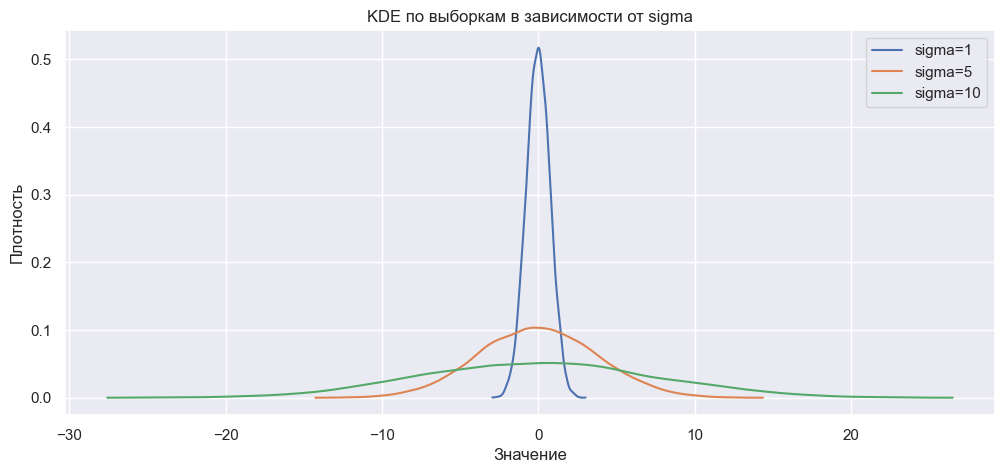

In [66]:
plt.figure(figsize=(12,5))
for sigma in sigmas:
    cur_sample = P_samples[sigma]
    kde = gaussian_kde(cur_sample)
    x_values = np.linspace(min(cur_sample), max(cur_sample), int(N))
    kde_values = kde(x_values)
    plt.plot(x_values, kde_values, label=f"sigma={sigma}")

plt.title('KDE по выборкам в зависимости от sigma')
plt.xlabel('Значение')
plt.ylabel('Плотность')

plt.legend()
plt.show()

По графикам KDE видно, что графики ведут себя также как нормальное распределение. 

3) Изучить поведение плотности с ростом $n$.

Как мы знаем из курса теории вероятностей, сходимость по распределению эквивалентна поточечной сходимости функций распределения. Теория из мат. анализа гарантирует сходимость функций при наличии сходимости их производных при выполнении некоторых других регулярных условий (см. курс мат. анализа). На практике выводы о наличии сходимости по распределению делаются при помощи демонстрации сходимости плотностей.

На одном графике изобразите жирной линией одного цвета плотность предельного распределения, посчитанного в пункте 1. Не считайте плотность нормального распределения руками, вместо этого используйте scipy.

В тех же осях изобразите полупрозрачными линиями плотности величин P для N = 1000, 2000, ..., 10000.

[ 1000.  2000.  3000.  4000.  5000.  6000.  7000.  8000.  9000. 10000.]


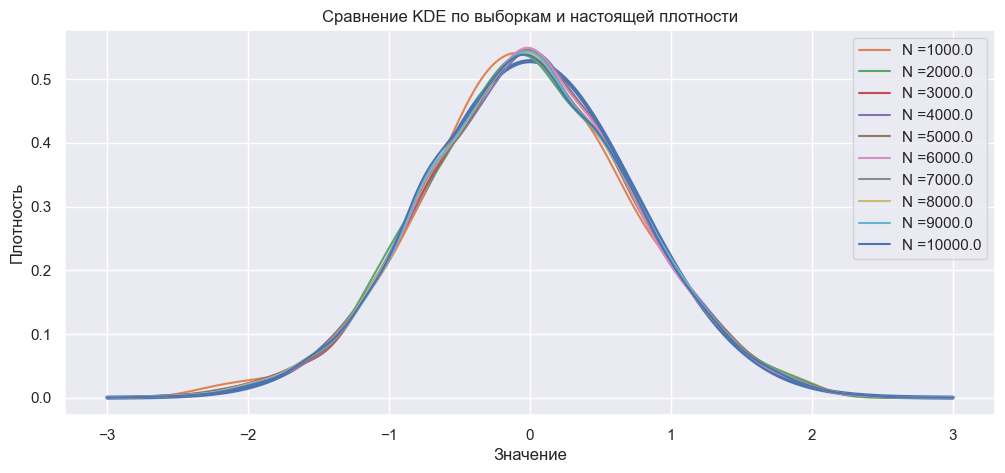

In [56]:
plt.figure(figsize=(12,5))
N_array = np.linspace(1000, 10000, 10)
print(N_array)
sigma = 1
x_values = np.linspace(-3, 3, 10000)
plt.plot(x_values, sps.norm(0, np.sqrt(sigma**2 * (np.pi/2 - 1))).pdf(x_values), linewidth=3)
for N in N_array:
    cur_sample = P_samples[sigma][:int(N)+1]
    kde = gaussian_kde(cur_sample)
    kde_values = kde(x_values)
    plt.plot(x_values, kde_values, label=f"N ={N}")

plt.title('Сравнение KDE по выборкам и настоящей плотности')
plt.xlabel('Значение')
plt.ylabel('Плотность')

plt.legend()
plt.show()


Сделайте выводы о том, видна ли сходимость? Как Вы это поняли?

Вывод: сходимость видна, так как графики плотности сходятся с увеличением N. Это видно так как с ростом N они почти совпадают с действительной плотностью.

Также иногда доказывают равномерную сходимость плотностей по определению.

Выберите достаточно малое $\varepsilon$ и заштрихуйте на графике область точек, где находятся графики функций $g$, для которых верно $|g(x) - f(x)| \leq \varepsilon$ для любых $x$, где $f$ --- предельная плотность.

Полупрозрачными линиями нарисуйте графики плотностей величины $P$ для достаточно больших $N$.

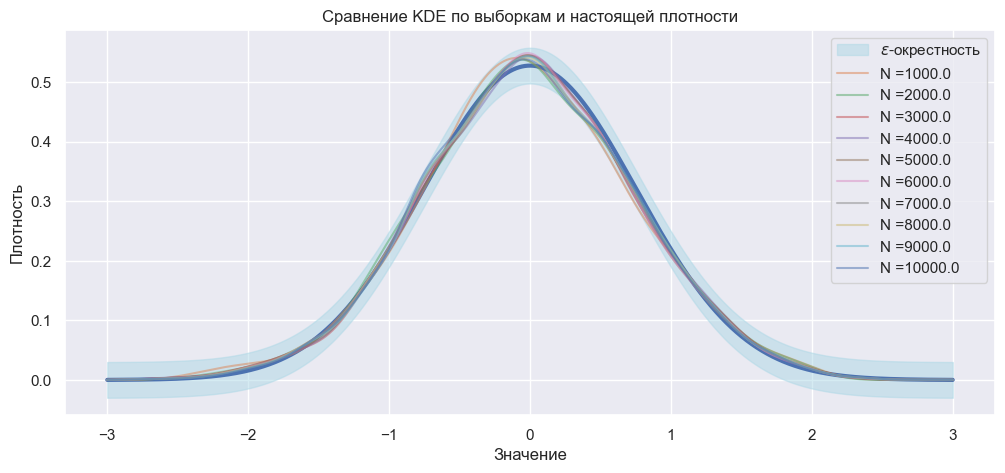

In [61]:
epsilon = 0.03
plt.figure(figsize=(12,5))
plt.plot(x_values, sps.norm(0, np.sqrt(sigma**2 * (np.pi/2 - 1))).pdf(x_values), linewidth=3)
plt.fill_between(x_values, sps.norm(0, np.sqrt(sigma**2 * (np.pi/2 - 1))).pdf(x_values) - epsilon, sps.norm(0, np.sqrt(sigma**2 * (np.pi/2 - 1))).pdf(x_values) + epsilon, color='lightblue', alpha=0.5, label=r'$\varepsilon$-окрестность')  # Окрестность
for N in N_array:
    cur_sample = P_samples[sigma][:int(N)+1]
    kde = gaussian_kde(cur_sample)
    kde_values = kde(x_values)
    plt.plot(x_values, kde_values, label=f"N ={N}", alpha = 0.5)
plt.title('Сравнение KDE по выборкам и настоящей плотности')
plt.xlabel('Значение')
plt.ylabel('Плотность')

plt.legend()
plt.show()


Верно ли, что для всех больших $N$ графики лежат в окрестности предела? Проверьте это условие численно для какой-нибудь сетки точек.
Доделайте доказательство сходимости по распределению.

In [62]:
x_values = np.linspace(-3, 3, 10000)
real_values = sps.norm(0, np.sqrt(sigma**2 * (np.pi/2 - 1))).pdf(x_values)
for N in N_array:
    cur_sample = P_samples[sigma][:int(N)+1]
    print
    kde = gaussian_kde(cur_sample)
    kde_values = kde(x_values)
    if np.all(np.abs(kde_values - real_values) < epsilon):
        print(f'Для N = {N} график плотности входит в epsilon-окрестность настоящей плотности')
    else:
        print(f'Для N = {N} график плотности не входит в epsilon-окрестность настоящей плотности')

Для N = 1000.0 график плотности входит в epsilon-окрестность настоящей плотности
Для N = 2000.0 график плотности не входит в epsilon-окрестность настоящей плотности
Для N = 3000.0 график плотности входит в epsilon-окрестность настоящей плотности
Для N = 4000.0 график плотности входит в epsilon-окрестность настоящей плотности
Для N = 5000.0 график плотности входит в epsilon-окрестность настоящей плотности
Для N = 6000.0 график плотности входит в epsilon-окрестность настоящей плотности
Для N = 7000.0 график плотности входит в epsilon-окрестность настоящей плотности
Для N = 8000.0 график плотности входит в epsilon-окрестность настоящей плотности
Для N = 9000.0 график плотности входит в epsilon-окрестность настоящей плотности
Для N = 10000.0 график плотности входит в epsilon-окрестность настоящей плотности


Ответ:

Видно, что начиная с N=3000 все графики входят в epsilon-окрестность.　Это как раз и говорит о том, что плотности сходятся, а значит и сходятся случайные величины по распределению.

Сделайте вывод о возможности применения KDE для визуализации поведения распределений.

Вывод: Оценка плотности методом KDE является мощным инструментом для визуализации поведения распределений данных. Она позволяет по выборке сделать непрерывную апроксимацию плотности распределения. Таким образом можно сравнить настоящее распределение с графиком KDE и сделать нужные нам выводы про сходимость по распределению.

### Задача 3

В этой задаче мы будем учиться проверять сходимость по мере случайных величин к константе (позже это свойство назовут состоятельностью).

Будем работать с распределением $U[0, \theta]$ --- равномерным распределением на отрезке и оценкой $\hat{\theta} = \frac{n+1}{n}X_{(n)}$, где $X_{(i)}$ --- $i$-тый член вариационного ряда выборки ($i$-тое по порядку число, если выборку отсортировать), то есть оценивать параметр мы будем максимумом.

Мы будем численно доказывать, что это состоятельная оценка (т.е. она сходится по мере к значению параметра).

Сгенерируйте по одной оценке $\theta$ для $N$ от 1 до 1000.

In [85]:
theta = 1
N = 1000
sample = sps.uniform(0,theta).rvs(size = N)
theta_eval = np.maximum.accumulate(sample)
range = np.arange(1, N + 1)
theta_eval = theta_eval * ((range + 1)/ range)
theta_eval

array([1.64246192, 1.34011283, 1.19121141, 1.11676069, 1.15688233,
       1.12474671, 1.10179269, 1.08457718, 1.07118734, 1.06047547,
       1.05171121, 1.04440766, 1.03822773, 1.03293065, 1.02833985,
       1.02432289, 1.02077852, 1.01762797, 1.01480906, 1.01227204,
       1.00997664, 1.00788991, 1.00598463, 1.00423813, 1.00263135,
       1.00114817, 0.99977485, 0.99849963, 0.99731235, 0.99620423,
       0.99516759, 0.99419575, 0.99328281, 0.99242357, 0.99161342,
       0.99084829, 0.99012451, 0.98943883, 0.98878831, 0.98817032,
       0.98758247, 0.98702262, 0.98648881, 0.98597926, 0.98549235,
       0.98502662, 0.9845807 , 0.98415337, 0.98374348, 0.98334998,
       0.98297191, 0.98260839, 0.98225858, 0.98192173, 0.98159713,
       0.98128412, 1.00274967, 1.00245158, 1.00216361, 1.00188523,
       1.00161598, 1.00851121, 1.00825711, 1.00801095, 1.00777237,
       1.00754102, 1.00731657, 1.00709873, 1.0068872 , 1.00668171,
       1.00648201, 1.00628786, 1.00609903, 1.0059153 , 1.00573

Отобразите на графике в осях $n, \theta$ поведение этой оценки. Сходится ли она? Как быстро?

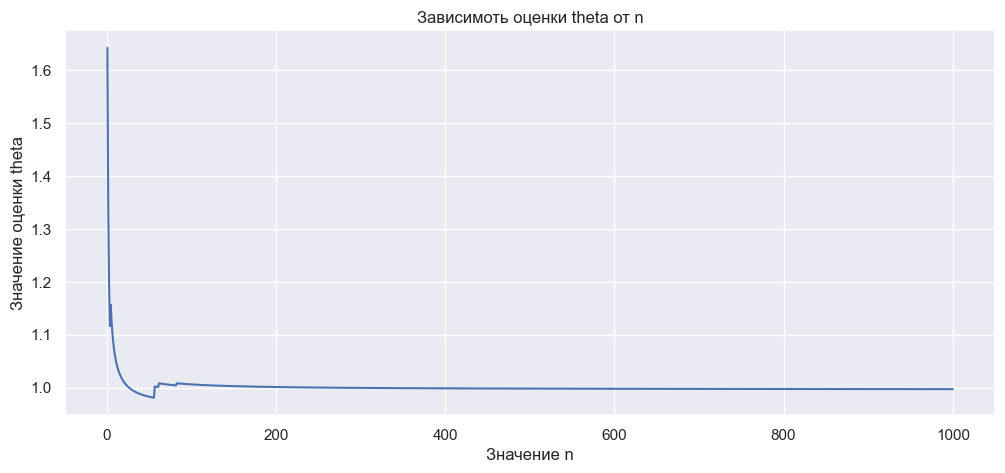

In [86]:
plt.figure(figsize = (12, 5))
plt.title("Зависимоть оценки theta от n")
plt.ylabel("Значение оценки theta")
plt.xlabel("Значение n")
plt.plot(range, theta_eval)
plt.show()

Видно, что график находится достаточно близко к $\theta$ = 1 начиная с $n=100$ и дальше убывает все ближе и ближе.

По одной траектории, конечно, вывод о сходимости по вероятности делать нельзя.

Почему?

Ответ: Могло получится так, что мы получили удачную выборку и соответственно для нее все хорошо сходится, поэтому надо проверить больше траекторий для того, чтобы делать какие-либо выводы.

Для сходимости по мере нужно изучить поведение многих траекторий. По определению, $P(|\hat{\theta}_n - \theta| > \varepsilon)$ сходится к нулю. То есть для любого наперёд заданного эпсилон с ростом $n$ всё больше и больше траекторий должны попадать в эпсилон-окрестность истинного значения параметра.

Проверим.

На одном графике изобразите:

1) Горизонтальные прямые --- значение параметра и его эпсилон-окрестности (заштрихуйте её и выделите границы)

2) Сгенерируйте 1000 траекторий поведения оценки и полупрозрачными линиями нарисуйте их.

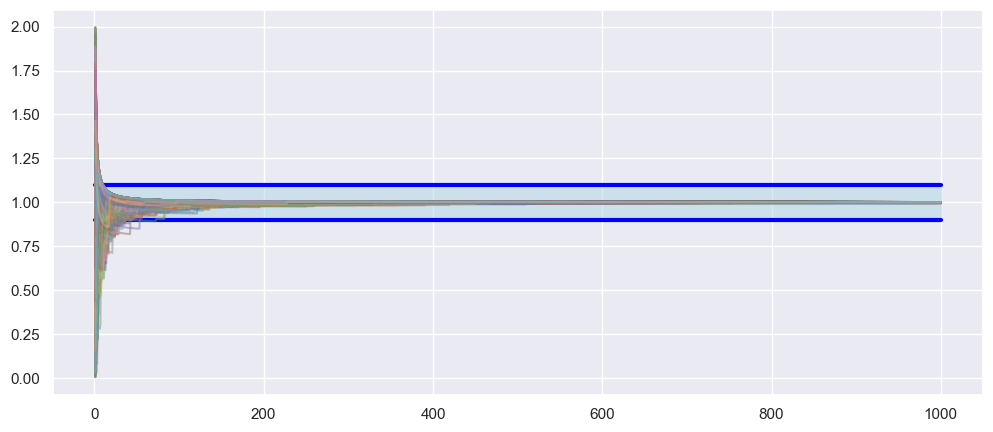

In [87]:
epsilon = 0.1
theta_upper = theta + epsilon
theta_lower = theta - epsilon
sample_of_samples = sps.uniform(0, theta).rvs(size = (N, N))
theta_eval = np.maximum.accumulate(sample_of_samples, axis=1)
theta_eval = theta_eval * (range + 1)/range
plt.figure(figsize = (12, 5))
plt.fill_between(range, theta_lower, theta_upper, color='lightblue', alpha=0.5, label=r'$\epsilon$-окрестность')
plt.plot(range, np.full(N, theta_upper), linewidth = 3, label=r'Верхняя граница ($y_0 + \epsilon$)', color = "blue")
plt.plot(range, np.full(N, theta_lower), linewidth = 3, label=r'Нижняя граница ($y_0 - \epsilon$)', color = "blue")
for n in np.arange(N):
    plt.plot(range, theta_eval[n], alpha=0.5)
plt.show()

На графике видно, что начиная с $n=200$ все траектории входят в $\varepsilon$-окрестность.

Численно проверьте, какая доля траекторий не попадает в окрестность для каждого $N$. Сходится ли это число к нулю?

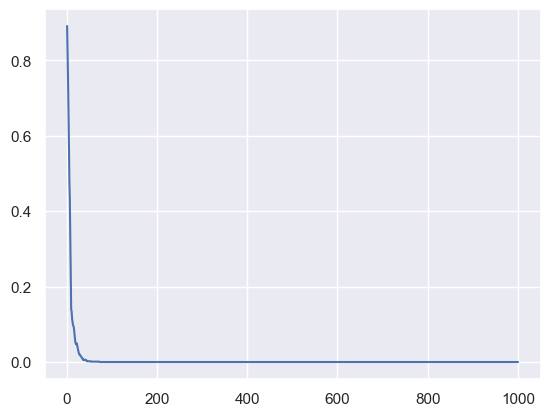

In [88]:
proportions = np.mean((np.abs(theta_eval - theta) >= epsilon), axis=0)
plt.plot(range, proportions)

Сделайте вывод о том, наблюдается ли сходимость по мере.

Вывод: Видно по графику, что доля траекторий, которые не входят в $\varepsilon$-окрестность стремится к 0. Это как раз и свидетельствует о сходиомости по мере, так как по определению для любого $\varepsilon$ доля траекторий с ростом n не входящих в $\varepsilon$ окрестность должна стремиться к 0. 

Повторите эксперимент для 2-3 разных $\theta$ и сделайте выводы.

Проведем эксперемент для $theta=5$ и $theta=10$.

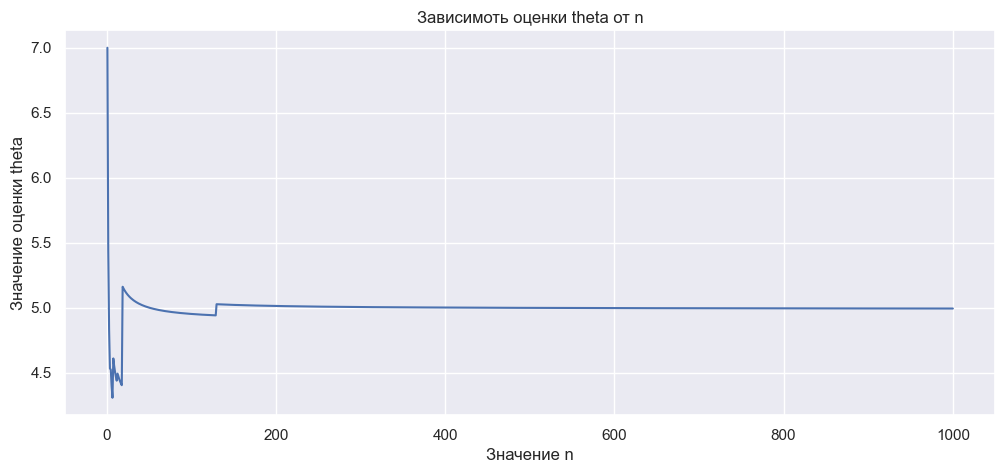

In [89]:
theta = 5
sample = sps.uniform(0,theta).rvs(size = N)
theta_eval = np.maximum.accumulate(sample)
range = np.arange(1, N + 1)
theta_eval = theta_eval * ((range + 1)/ range)
theta_eval
plt.figure(figsize = (12, 5))
plt.title("Зависимоть оценки theta от n")
plt.ylabel("Значение оценки theta")
plt.xlabel("Значение n")
plt.plot(range, theta_eval)
plt.show()

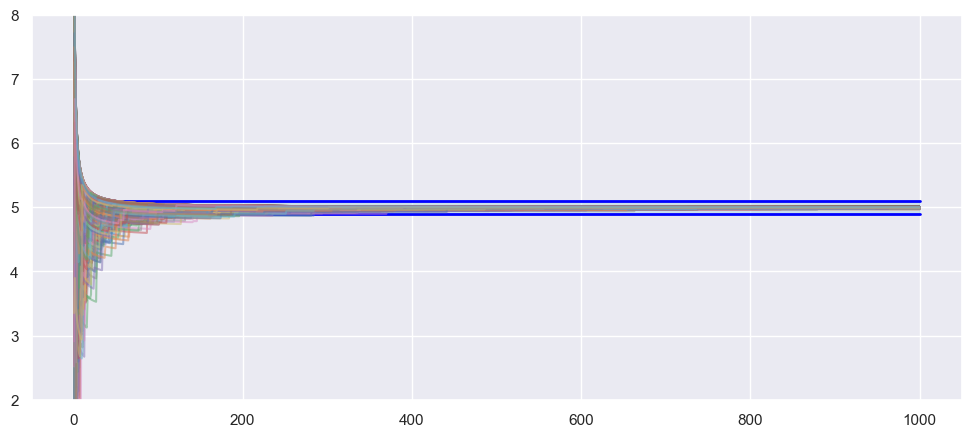

In [90]:
epsilon = 0.1
theta_upper = theta + epsilon
theta_lower = theta - epsilon
sample_of_samples = sps.uniform(0, theta).rvs(size = (N, N))
theta_eval = np.maximum.accumulate(sample_of_samples, axis=1)
theta_eval = theta_eval * (range + 1)/range
plt.figure(figsize = (12, 5))
plt.ylim(2, 8)
plt.fill_between(range, theta_lower, theta_upper, color='lightblue', alpha=0.5, label=r'$\epsilon$-окрестность')
plt.plot(range, np.full(N, theta_upper), linewidth = 2, label=r'Верхняя граница ($y_0 + \epsilon$)', color = "blue")
plt.plot(range, np.full(N, theta_lower), linewidth = 2, label=r'Нижняя граница ($y_0 - \epsilon$)', color = "blue")
for n in np.arange(N):
    plt.plot(range, theta_eval[n], alpha=0.5)
plt.show()

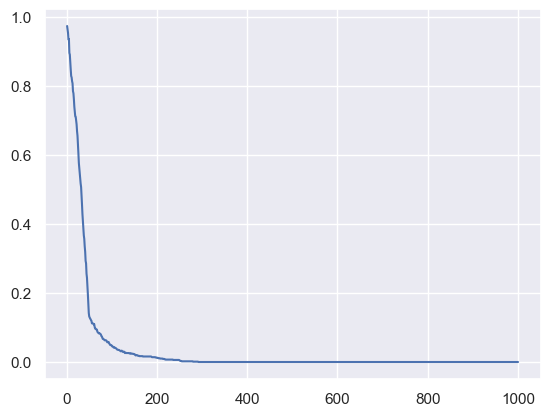

In [83]:
proportions = np.mean((np.abs(theta_eval - theta) >= epsilon), axis=0)
plt.plot(range, proportions)

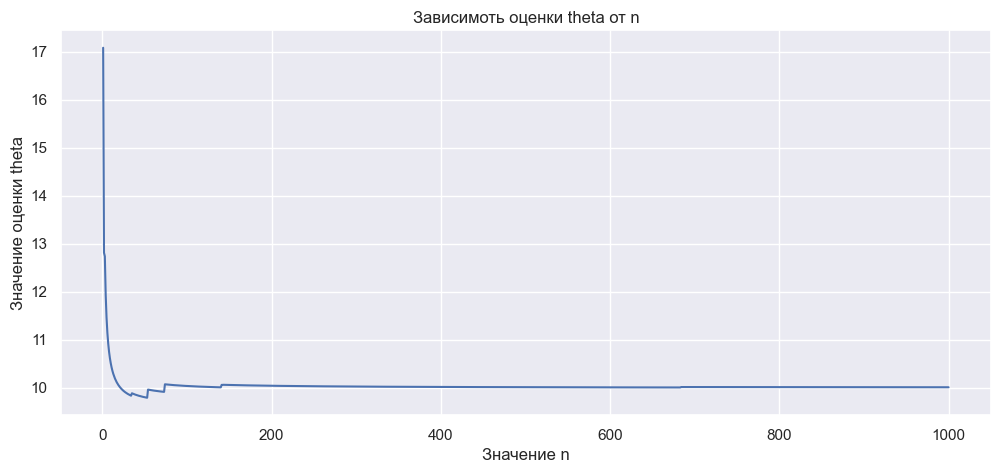

In [91]:
theta = 10
sample = sps.uniform(0,theta).rvs(size = N)
theta_eval = np.maximum.accumulate(sample)
range = np.arange(1, N + 1)
theta_eval = theta_eval * ((range + 1)/ range)
theta_eval
plt.figure(figsize = (12, 5))
plt.title("Зависимоть оценки theta от n")
plt.ylabel("Значение оценки theta")
plt.xlabel("Значение n")
plt.plot(range, theta_eval)
plt.show()

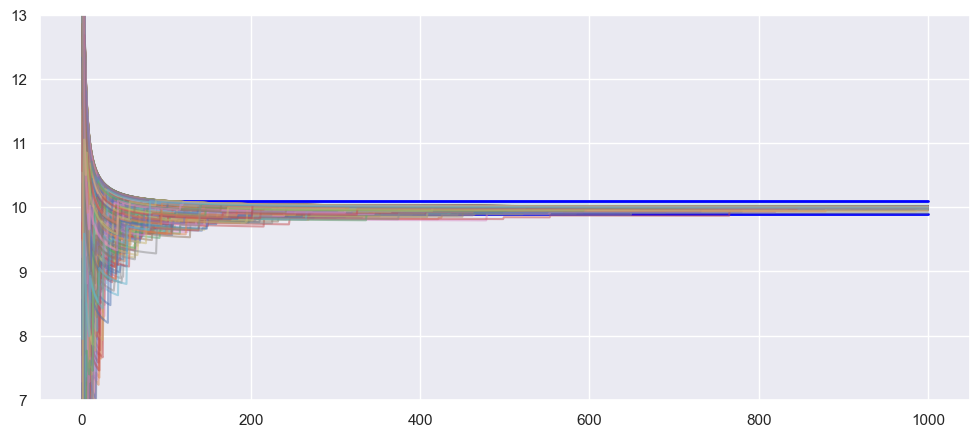

In [94]:
epsilon = 0.1
theta_upper = theta + epsilon
theta_lower = theta - epsilon
sample_of_samples = sps.uniform(0, theta).rvs(size = (N, N))
theta_eval = np.maximum.accumulate(sample_of_samples, axis=1)
theta_eval = theta_eval * (range + 1)/range
plt.figure(figsize = (12, 5))
plt.ylim(7, 13)
plt.fill_between(range, theta_lower, theta_upper, color='lightblue', alpha=0.5, label=r'$\epsilon$-окрестность')
plt.plot(range, np.full(N, theta_upper), linewidth = 2, label=r'Верхняя граница ($y_0 + \epsilon$)', color = "blue")
plt.plot(range, np.full(N, theta_lower), linewidth = 2, label=r'Нижняя граница ($y_0 - \epsilon$)', color = "blue")
for n in np.arange(N):
    plt.plot(range, theta_eval[n], alpha=0.5)
plt.show()

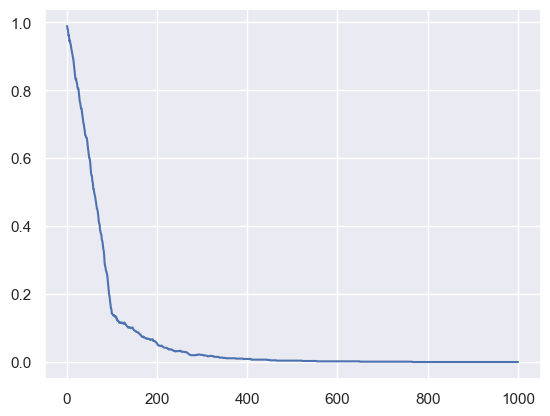

In [95]:
proportions = np.mean((np.abs(theta_eval - theta) >= epsilon), axis=0)
plt.plot(range, proportions)

Вывод: Видно, что с ростом $\theta$ траектории медленее сходятся к предельному значению. Однако все равно доля траекторий не входящих в $\epsilon$ окрестность стремится к 0, что свидетельствует о сходимости по мере.

**Бонусный вопрос:** (баллами не оценивается, но даёт пищу для ума).

На практике статистики не отличают состоятельность от сильной состоятельности и проверяют оба свойства одинаково. Годится ли наш метод практической проверки для проверки сильной состоятельности? Как можно было бы проверить её качественнее?

Ответ: